In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats

import sys

from analysis import spikingResponse # custom object of trial-aligned spiking reponse
from analysis import pt, crosscorrel # plot_tools and CC-function

import matplotlib.pyplot as plt

# just to disable the HDMF cache namespace warnings, REMOVE to see them
import warnings
warnings.filterwarnings("ignore")

 /!\  "svgutils" not installed ! get it with: "pip install svgutils" 


# 1) Loading the Optotagging results

In [2]:
#Optotagging = np.load(os.path.join('..', 'data', 'visual_coding', 'Optotagging-Results.npy'), allow_pickle=True).item()
Optotagging = np.load(os.path.join('..', 'data', 'visual_coding', 'Optotagging-Results.npy'), allow_pickle=True).item()

# randomly subsample the negative units to 100 cells per session
np.random.seed(1)
for key in ['PV','SST']:
    for n, nUnits in enumerate(Optotagging[key+'_negative_units']):
        Optotagging[key+'_negative_units'][n] = np.random.choice(nUnits, 100, replace=False)

# 2) Preprocess the stimulus-evoked spikes

In [3]:
all = True

tstart, tstop, dt = -1, 301, 1e-3
t = tstart+dt*np.arange(int((tstop-tstart)/dt))

if False:
    # turn True to re-run the analysis
    
    # load data from API
    from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
    data_directory = os.path.join(os.path.expanduser('~'), 'Downloads', 'ecephys_cache_dir')
    manifest_path = os.path.join(data_directory, "manifest.json")
    cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
    sessions = cache.get_session_table()
    
    for key in ['PV', 'SST']:
        # loop over session

        for sessionID, positive_units, negative_units in zip(Optotagging[key+'_sessions'],
                                                             Optotagging[key+'_positive_units'],
                                                             Optotagging[key+'_negative_units']):
            if all:
                units  = np.concatenate([positive_units, negative_units])
            else:
                units = positive_units
            
            session = cache.get_session_data(sessionID)
            # stimulus infos for that session
            stim_table = session.get_stimulus_table()
            # fetch summary statistics 
            analysis_metrics = cache.get_unit_analysis_metrics_by_session_type(session.session_type)
            
            for protocol in [\
                             #'natural_movie_one_more_repeats',
                             'natural_movie_two',
                             #'natural_movie_one',
                             'natural_movie_three']:
                if protocol in np.unique(stim_table.stimulus_name):
                    cond = (stim_table.stimulus_name==protocol)
                    # get the number of repeats
                    blocks = np.unique(stim_table[cond].stimulus_block)
                    print(sessionID, protocol, 'n=%i blocks' % len(blocks))
                    for unit in units:
                        spike_matrix = np.zeros((len(blocks),len(t)), dtype=bool)
                        # get the spikes of that unit
                        spike_times = session.spike_times[unit]
                        # then just iterate over stimulus block:
                        for trial_idx, b in enumerate(blocks):
                            bCond = cond & (stim_table.stimulus_block==b)
                            trial_start = np.min(stim_table[bCond].start_time)
                            #tstop = np.max(stim_table[bCond].stop_time)
                            in_range = (spike_times > (trial_start + t[0])) * \
                                       (spike_times < (trial_start + t[-1]))
                            binned_times = ((spike_times[in_range] -\
                                             (trial_start + t[0])) / dt).astype('int')
                            spike_matrix[trial_idx, binned_times] = True      
                        Data = {'time_resolution':dt, 
                                'spike_matrix':spike_matrix,
                                't':t, 'keys':['t', 'spike_matrix']}
                        np.save(os.path.join('..', 'data', 'visual_coding', key,
                                             '%s_unit_%i.npy' % (protocol, unit)),
                                Data)

# 3) Showing an example session response

PV  -> sessionID:  721123822
number of repeats: 2    positive PV
number of repeats: 2    negative PV
SST  -> sessionID:  756029989
number of repeats: 2    positive SST
number of repeats: 2    negative SST


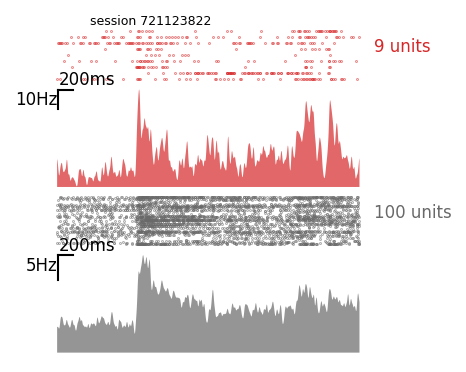

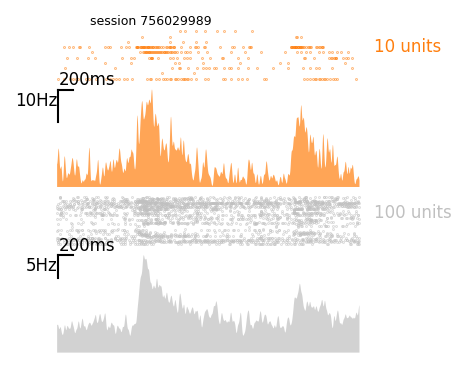

In [70]:
examples = {'PV':{'sessionID':0, 'positive_color':'tab:red', 'negative_color':'dimgrey'},
            'SST':{'sessionID':2, 'positive_color':'tab:orange', 'negative_color':'silver'}}

rate_smoothing = 10e-3
tmax = 3


for c, cellType in enumerate(examples.keys()):

    fig, AX = pt.figure(axes_extents=[[[1,1]],[[1,2]],[[1,1]],[[1,2]]], hspace=0.1, figsize=(1.6,.55))
    sessionID = examples[cellType]['sessionID']
    fig.suptitle('session %i\n' % Optotagging['%s_sessions' % cellType][sessionID], fontsize=6)
    print(cellType, ' -> sessionID: ', Optotagging['%s_sessions' % cellType][sessionID])

    for k, key in enumerate(['positive', 'negative']):
        rates = []
        for u, unit in enumerate(Optotagging['%s_%s_units' % (cellType, key)][sessionID]):
            for protocol in ['natural_movie_one', 'natural_movie_one_more_repeats']:
                filename = os.path.join('..', 'data', 'visual_coding', cellType, 
                                        '%s_unit_%i.npy' % (protocol, unit))
                if os.path.isfile(filename):
                    spikeResp = spikingResponse(None, None, None, filename=filename)
                    cond = spikeResp.t<tmax
                    rates.append(spikeResp.get_rate(smoothing=rate_smoothing)[cond])

                    # showing spikes on the first repeat only
                    sCond = spikeResp.spike_matrix[0,:] & cond
                    AX[2*k].scatter(spikeResp.t[sCond], u+0*spikeResp.t[sCond], 
                                    s=0.05,
                                    color=examples[cellType]['%s_color'%key])
        print('number of repeats:', spikeResp.spike_matrix.shape[0], '  ', key, cellType)

        AX[2*k+1].fill_between(spikeResp.t[cond], 0*spikeResp.t[cond], np.mean(rates, axis=0),
                               alpha=.7, lw=0,
                               color=examples[cellType]['%s_color'%key])
        pt.annotate(AX[2*k], '%i units' % len(rates), (1,0.5),
                               color=examples[cellType]['%s_color'%key])
    for ax in AX:
        ax.axis('off')
    pt.draw_bar_scales(AX[1], Xbar=0.2, Xbar_label='200ms', Ybar=10, Ybar_label='10Hz')
    pt.draw_bar_scales(AX[3], Xbar=0.2, Xbar_label='200ms', Ybar=5, Ybar_label='5Hz')
    pt.set_common_xlims(AX)
    fig.savefig('../figures/visual_coding/%s-session-natural-movie.svg' % cellType)

# 4) Compute the time-varying rate of the "+" and "-" units 

In [8]:
# loop over frames to build the time course

rate_smoothing = 10e-3

PROTOCOLS = {'natural_movie_three':['natural_movie_three'],
             'natural_movie_one':['natural_movie_one',
                                  'natural_movie_one_more_repeats']}

for p in PROTOCOLS:
    
    protocols = PROTOCOLS[p]

    RATES = {}
    for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
        RATES[key+'_posUnits'] = []
        RATES[key+'_negUnits'] = []
        for sessionID in range(len(Optotagging[key+'_sessions'])):
            
            if len(Optotagging[key+'_positive_units'][sessionID])>1:
                # only sessions with phototagged units
                
                for u, rates, units, c in zip(range(2), [RATES[key+'_posUnits'], RATES[key+'_negUnits']],
                                       [Optotagging[key+'_positive_units'][sessionID], Optotagging[key+'_negative_units'][sessionID]],
                                       [color, 'tab:grey']):
                    
                    for unit in units:
                        for protocol in protocols:
                            filename = os.path.join('..', 'data', 'visual_coding', key, 
                                                    '%s_unit_%i.npy' % (protocol, unit))
                            if os.path.isfile(filename):
                                spikeResp = spikingResponse(None, None, None, filename=filename)
                                rates.append(spikeResp.get_rate(smoothing=rate_smoothing))
                            
    RATES['time'] = spikeResp.t
    np.save(os.path.join('..', 'data', 'visual_coding', 'RATES_%s.npy' % p), RATES)

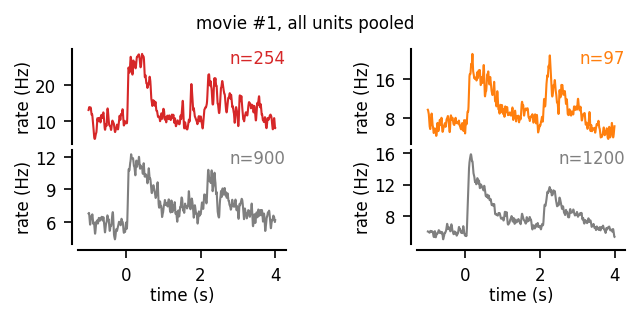

In [12]:
RATES = np.load(os.path.join('..', 'data', 'visual_coding', 'RATES_natural_movie_one.npy'),
                allow_pickle=True).item()

fig, AX = pt.figure(axes=(2,2), hspace=0.1, figsize=(1.3,1))
fig.suptitle('movie #1, all units pooled')

tCond = RATES['time']<4

for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    for u, rates, c in zip(range(2), 
                           [RATES[key+'_posUnits'], RATES[key+'_negUnits']],
                           [color, 'tab:grey']):  
        if len(rates)>0:
            pt.plot(RATES['time'][tCond], np.mean(rates, axis=0)[tCond],
                    #sy=0.*np.std(rates, axis=0)[tCond],
                    ax=AX[u][k], color=c)
            pt.annotate(AX[u][k], 'n=%i' % len(rates), (1,1), va='top', ha='right', color=c)
            pt.set_plot(AX[u][k], ['left','bottom'] if u else ['left'], 
                        ylabel='rate (Hz)', xlabel='time (s)' if u else '')

# 5) Compute the Cross.-Correlation and its decay

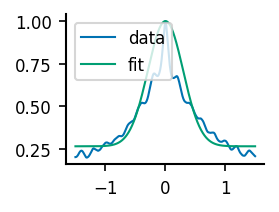

In [9]:
# Exponential fit to quantify the decay

from scipy.optimize import minimize
"""
def fit_exponential_decay(shift, array,
                          min_time=100e-3,
                          max_time=1300e-3):
    def func(X):
        return np.sum(np.abs((1-X[1])*np.exp(-shift/X[0])+X[1]-array))
    res = minimize(func, [min_time,1],
                   bounds=[[min_time, max_time]], method='L-BFGS-B')
    return res.x
ts, ccf = time_shift[int(len(time_shift)/2):], CCF[int(len(time_shift)/2):]/CCF[int(len(time_shift)/2)]
tau, C = fit_exponential_decay(ts, ccf)
plt.plot(ts, ccf, label='data')
plt.plot(ts, (1-C)*np.exp(-ts/tau)+C, '--', label='exp. fit')
"""

def gaussian(t, X):
    return (1-X[2])*np.exp(-(t-X[1])**2/2/X[0]**2)+X[2]
                 
def fit_gaussian_width(shift, array,
                       min_time=100e-3,
                       max_time=1000e-3):
    def func(X):
        return np.sum(np.abs(gaussian(shift, X)-array))
    res = minimize(func, [3*min_time,0,1],
                   bounds=[[min_time, max_time],
                           [-max_time, max_time],
                           [0,1]], method='L-BFGS-B')
    return res.x

plt.plot(time_shift, CCF/np.max(CCF), label='data')
plt.plot(time_shift, gaussian(time_shift, fit_gaussian_width(time_shift, CCF/np.max(CCF))), label='fit')

#plt.plot(ts, (1-C)*np.exp(-ts/tau)+C, '--', label='exp. fit')
plt.legend()

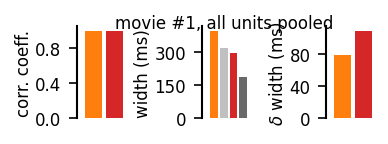

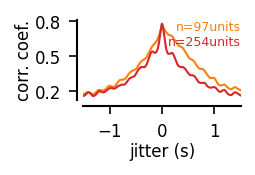

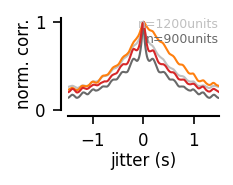

In [11]:

RATES = np.load(os.path.join('..', 'data', 'visual_coding', 'RATES_natural_movie_one.npy'),
                allow_pickle=True).item()

fig1, [ax11, ax12, ax13] = plt.subplots(1, 3, figsize=(2.5,0.8))
fig1.subplots_adjust(wspace=2)
fig1.suptitle('movie #1, all units pooled')
fig2, ax2 = pt.figure(figsize=(1.1,0.85))
fig3, ax3 = plt.subplots(1, figsize=(1.3, 0.8))


for k, key, pos_color, neg_color in zip(range(2),
                                        ['SST', 'PV'], 
                                        ['tab:orange', 'tab:red'],
                                        ['silver', 'dimgrey']):

    neg_rates = np.mean(RATES['%s_negUnits' % key], axis=0)
    pos_rates = np.mean(RATES['%s_posUnits' % key], axis=0)
    pt.annotate(ax2, k*'\n'+'n=%iunits' % len(RATES['%s_posUnits' % key]), (1,1),
                va='top', ha='right', color=pos_color, fontsize=6)
    pt.annotate(ax3, k*'\n'+'n=%iunits' % len(RATES['%s_negUnits' % key]), (1,1),
                va='top', ha='right', color=neg_color, fontsize=6)
    
    CCF, time_shift = crosscorrel(neg_rates-np.mean(neg_rates), neg_rates-np.mean(neg_rates),
                                  1.5, RATES['time'][1]-RATES['time'][0])
    ax3.plot(time_shift, CCF/np.max(CCF), color=neg_color)
    
    # gaussian fit for width
    tau0 = fit_gaussian_width(time_shift, CCF/np.max(CCF))[0]
    ax12.bar([2*k+1], [1e3*tau0], color=neg_color)

    ax11.bar([k], [CCF[int(len(time_shift)/2)]], color=pos_color)

    CCF, time_shift = crosscorrel(neg_rates-np.mean(neg_rates), pos_rates-np.mean(pos_rates),
                                  1.5, RATES['time'][1]-RATES['time'][0])
    ax2.plot(time_shift, CCF, color=pos_color)
    ax3.plot(time_shift, CCF/np.max(CCF), color=pos_color)
    
    # gaussian fit for width
    tau = fit_gaussian_width(time_shift, CCF/np.max(CCF))[0]
    ax12.bar([2*k], [1e3*tau], color=pos_color)
    #ax13.bar([k], [1e3*(tau-tau0)], color=pos_color)
    
pt.set_plot(ax11, ['left'], #yticks=[0,0.2,0.4],
            ylabel='corr. coeff.')
pt.set_plot(ax12, ['left'], #yticks=[0,0.2,0.4],
            ylabel='width (ms)')
pt.set_plot(ax13, ['left'], #yticks=[0,0.2,0.4],
            ylabel='$\delta$ width (ms)')
pt.set_plot(ax2, xlabel='jitter (s)', 
            #title='"-" vs "+" units', 
            ylabel='corr. coef.',
            yticks=[0.2,0.5,0.8],
            xlim=[-1.5,1.5])
pt.set_plot(ax3, xlabel='jitter (s)', 
            ylabel='norm. corr.',
            xlim=[-1.5,1.5], yticks=[0,1])

fig2.savefig('../figures/visual_coding/CC_movie1_units_pooled.svg')

# 6) Same but analyzing per session

## 6.1) compute the time-varying rate

In [56]:
# loop over frames to build the time course
PROTOCOLS = {'natural_movie_three':['natural_movie_three'],
             'natural_movie_one':['natural_movie_one', 'natural_movie_one_more_repeats']}

for p in PROTOCOLS:
    
    protocols = PROTOCOLS[p]
    
    RATES = {}
    for k, cellType, color in zip(range(2),
                             ['PV', 'SST'],
                             ['tab:red','tab:orange']):

        RATES['%s_posUnits' % cellType] = []
        RATES['%s_negUnits' % cellType] = []
        RATES['%s_n_per_session' % cellType] = []

        for sessionID in range(len(Optotagging[cellType+'_sessions'])):

            posUnits = Optotagging[cellType+'_positive_units'][sessionID]
            negUnits = Optotagging[cellType+'_negative_units'][sessionID]
            posRates, negRates = [], []

            for protocol in protocols:

                for units, rates in zip([negUnits, posUnits], [negRates, posRates]):
                    for unit in units:
                        filename = os.path.join('..', 'data', 'visual_coding', cellType, 
                                                '%s_unit_%i.npy' % (protocol, unit))
                        if os.path.isfile(filename):
                            spikeResp = spikingResponse(None, None, None, filename=filename)
                            rates.append(spikeResp.get_rate(smoothing=5e-3))

            if (len(posRates)>1):
                # only if more than one positive units
                RATES['%s_posUnits' % cellType].append(np.mean(posRates, axis=0))
                RATES['%s_negUnits' % cellType].append(np.mean(negRates, axis=0))
                RATES['%s_n_per_session' % cellType].append(len(posRates))
            else:
                #print('session %i no ' % sessionID, cellType, p)
                pass
                
    RATES['time'] = spikeResp.t
    np.save(os.path.join('..', 'data', 'visual_coding',
                         'RATES_per_session_%s.npy' % p), RATES)

## 6.2) Compute the cross-correlation

In [59]:
CCs = {'dt':RATES['time'][1]-RATES['time'][0],
       'extent':1.5}

for cellType in ['PV', 'SST']:
    for u in ['pos', 'neg']:
        CCs[cellType+'_%sUnits' % u] = []
    CCs['%s_n_per_session' % cellType] = []
    
for p in PROTOCOLS:
    
    RATES = np.load(os.path.join('..', 'data', 'visual_coding', 'RATES_per_session_%s.npy' % p),
                    allow_pickle=True).item()

    for k, cellType, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):

        for u in ['pos', 'neg']:
            
            for negRate, rate, n_per_session in zip(RATES['%s_negUnits' % cellType],
                                                    RATES['%s_%sUnits' % (cellType,u)],
                                                    RATES['%s_n_per_session' % cellType]):
                CCs[cellType+'_%sUnits' % u].append(\
                            crosscorrel(negRate, rate, CCs['extent'], CCs['dt'])[0])
                CCs['%s_n_per_session' % cellType].append(n_per_session)
                
# just to get the time shift
_, CCs['time_shift'] = crosscorrel(0*RATES['time'], 0*RATES['time'], CCs['extent'], CCs['dt'])

np.save(os.path.join('..', 'data', 'visual_coding', 'CC_per_session_natural_movies.npy'), CCs)

## 6.3) Analyze and plot

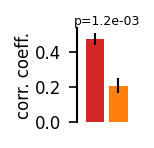

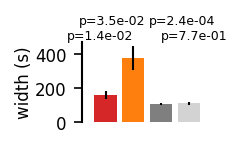

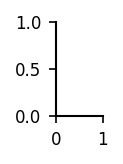

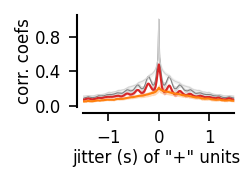

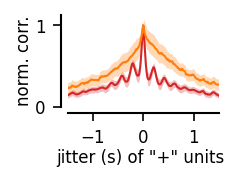

In [13]:
from scipy import stats

CCs = np.load(os.path.join('..', 'data', 'visual_coding', 'CC_per_session_natural_movies.npy'),
              allow_pickle=True).item()


fig11, ax11 = pt.figure(figsize=(.6,1.))
fig12, ax12 = pt.figure(figsize=(0.95,0.85))
fig13, ax13 = pt.figure(figsize=(.6,1.))
fig2, ax2 = plt.subplots(1, figsize=(1.3, 0.8))
fig3, ax3 = plt.subplots(1, figsize=(1.3, 0.8))

i0 = int(len(CCs['time_shift'])/2) # index of 0-lag correl

for k, cellType, color1, color2 in zip(range(2),
                                  ['PV', 'SST'],
                                  ['tab:red','tab:orange'],
                                  ['tab:grey', 'lightgray']):
    
    for i, pn, color in zip(range(2), ['pos', 'neg'], [color1, color2]):

        # 0-lag correl
        CCs['%s_%s0CC' % (cellType,pn)] = np.array([cc[i0] for cc in CCs['%s_%sUnits' % (cellType, pn)]])
        if not i:
            ax11.bar([k], [np.mean(CCs['%s_%s0CC' % (cellType,pn)])], 
                      yerr=[stats.sem(CCs['%s_%s0CC' % (cellType,pn)])],
                      color=color)

        # gaussian fit for width
        CCs['%s_%sWidths' % (cellType,pn)] = np.array([fit_gaussian_width(CCs['time_shift'], CCF/np.max(CCF))[0]\
                                                        for CCF in CCs['%s_%sUnits' % (cellType, pn)]])
        ax12.bar([k+2*i], [1e3*np.mean(CCs['%s_%sWidths' % (cellType,pn)])], 
                  yerr=[1e3*stats.sem(CCs['%s_%sWidths' % (cellType,pn)])],
                  color=color)
            
    mean = np.mean(CCs[cellType+'_posUnits'], axis=0)
    pt.plot(CCs['time_shift'], mean/np.max(mean),
            sy=stats.sem(CCs[cellType+'_negUnits'], axis=0)/np.max(mean),
            color=color1, ax=ax3)
    
    mean = np.mean(CCs[cellType+'_negUnits'], axis=0)
    pt.plot(CCs['time_shift'], mean/np.max(mean), 
            sy=stats.sem(CCs[cellType+'_negUnits'], axis=0)/np.max(mean),
            color=color2, lw=0.5, ax=ax2)
    pt.plot(CCs['time_shift'], np.mean(CCs[cellType+'_posUnits'], axis=0), 
            sy=stats.sem(CCs[cellType+'_posUnits'], axis=0)/np.max(mean),
            color=color1, ax=ax2)

# statistic
pt.annotate(ax11, 'p=%.1e' % stats.mannwhitneyu(CCs['PV_pos0CC'], CCs['SST_pos0CC']).pvalue,
            (0.5, 1.), ha='center', fontsize=6)

pt.annotate(ax12, 'p=%.1e' % stats.mannwhitneyu(CCs['PV_negWidths'], CCs['SST_negWidths']).pvalue,
            (0.9, 1.), ha='center', fontsize=6)
pt.annotate(ax12, 'p=%.1e' % stats.mannwhitneyu(CCs['PV_posWidths'], CCs['SST_posWidths']).pvalue,
            (0.1, 1.), ha='center', fontsize=6)
pt.annotate(ax12, 'p=%.1e\n' % stats.mannwhitneyu(CCs['PV_posWidths'], CCs['PV_negWidths']).pvalue,
            (0.2, 1.), ha='center', fontsize=6)
pt.annotate(ax12, 'p=%.1e\n' % stats.mannwhitneyu(CCs['SST_posWidths'], CCs['SST_negWidths']).pvalue,
            (0.8, 1.), ha='center', fontsize=6)

pt.set_plot(ax11, ['left'], #yticks=[0,0.2,0.4],
            ylabel='corr. coeff.')
pt.set_plot(ax12, ['left'], yticks=[0,200,400],
            ylabel='width (s)')
pt.set_plot(ax2, xlabel='jitter (s) of "+" units ', 
            ylabel='corr. coefs',
            xlim=[-1.5,1.5])
pt.set_plot(ax3, xlabel='jitter (s) of "+" units ', 
            ylabel='norm. corr.',
            xlim=[-1.5,1.5], yticks=[0,1])

fig12.savefig('../figures/visual_coding/decays_per_session.svg')

In [ ]:
stats.mannwhitneyu

## Cross-correlation per cell 
### (unusable --> rate waveforms are way too noisy at the required temporal sampling)

In [40]:
from scipy import signal

window = [-1.5, 1.5]

CCs = {'dt':RATES['time'][1]-RATES['time'][0],
       'extent':1.5}

for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    
    popRate = np.mean(RATES['%s_negUnits' % key], axis=0)

    # positive units
    CCs[key+'_posUnits'], CCs['time_shift'] = crosscorrel(popRate, popRate, CCs['extent'], CCs['dt'])
    
    # loop over negative units
    CCs[key+'_negUnits'] = []
    for rate in RATES['%s_negUnits' % key]:
        CCs[key+'_negUnits'].append(\
                        crosscorrel(popRate, rate, CCs['extent'], CCs['dt'])[0])
        
np.save(os.path.join('..', 'data', 'visual_coding', 'CC_natural_movie_one.npy'), CCs)

Text(0.5, 0.98, 'cross-correl. "-" vs "+" units')

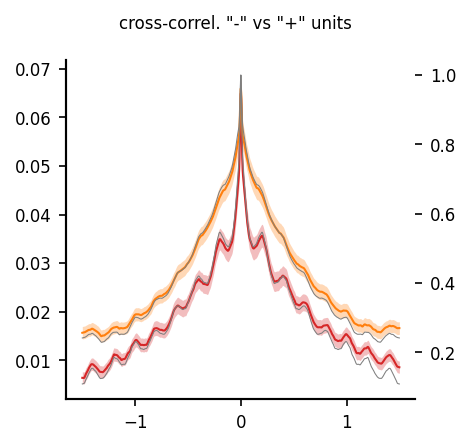

In [45]:
CCs = np.load(os.path.join('..', 'data', 'visual_coding', 'CC_natural_movie_one.npy'),
              allow_pickle=True).item()

fig, ax = plt.subplots(1, figsize=(3,3))
ax2 = ax.twinx()

for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    pt.plot(CCs['time_shift'], np.mean(CCs[key+'_negUnits'], axis=0), 
            sy=stats.sem(CCs[key+'_negUnits'], axis=0), color=color, ax=ax)
    pt.plot(CCs['time_shift'], CCs[key+'_posUnits'], 
            color='tab:grey', lw=0.5, ax=ax2)
    
#pt.set_plot(ax, xlabel='$\delta$ time (s)', xlim=[-1.5,1.5])
fig.suptitle('cross-correl. "-" vs "+" units')